In [2]:
import numpy as np 
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
from librosa.feature import mfcc
from IPython.display import display, clear_output

In [3]:
genre_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
file_path = [os.path.join(genre_path,x) for x in os.listdir(genre_path)]
genres = [x for x in os.listdir(genre_path)]

In [4]:
audio_paths = []
for i in tqdm(file_path):
    for j in os.listdir(i):
        file = os.path.join(i,j)
        audio_paths.append(file)

100%|██████████| 10/10 [00:00<00:00, 19.85it/s]


In [5]:
from IPython.display import Audio

In [6]:
demo = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav'
audio , sr = librosa.load(demo)
audio_wdt = Audio(data=audio,rate=sr)
display(audio_wdt)

In [7]:
def get_mfcc(path):
    audio, sr = librosa.load(path)
    mfccs = mfcc(y=audio,sr=sr,n_mfcc=13,hop_length=512,n_fft=2048)
    return mfccs

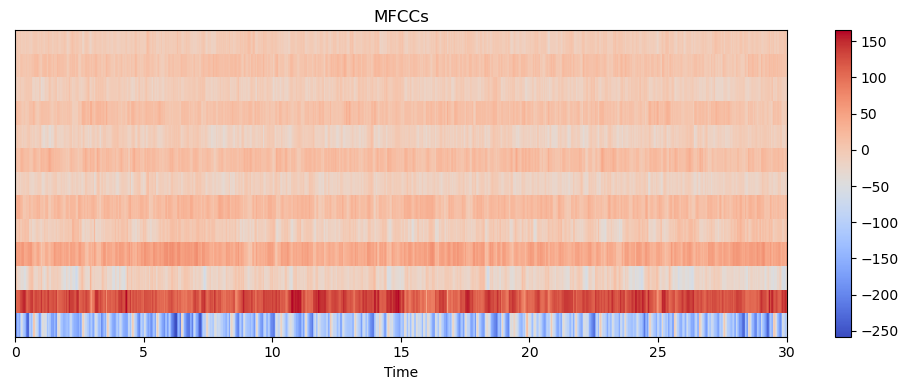

In [8]:
mfccs = get_mfcc('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav')
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.tight_layout()
plt.show()

In [9]:
def get_frame_mfccs(path):
  
    audio, sr = librosa.load(path)
    frames = librosa.util.frame(audio, frame_length=sr*3, hop_length=sr*3)
    frame_mfccs = []
    for i in range(frames.shape[1]):
        mfccs = mfcc(y=frames[:,i],sr=sr,n_mfcc=13,hop_length=512,n_fft=2048)
        frame_mfccs.append(mfccs)
    return frame_mfccs

In [10]:
frames_mfc = get_frame_mfccs(demo)

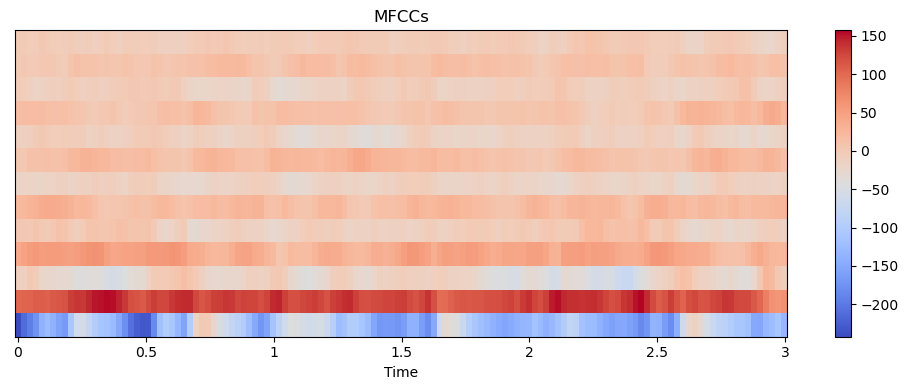

In [11]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(frames_mfc[0], x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.tight_layout()
plt.show()

In [12]:
data = []
labels = []
for path in tqdm(audio_paths):
    display(path)
    genre = path.split('/')[6]
    try:
        fmccs = get_frame_mfccs(path)
        clear_output(wait=True)
        for frame in fmccs:
            data.append(frame)
            labels.append(genre)
    except Exception:
        pass

100%|██████████| 1000/1000 [03:01<00:00,  5.52it/s]


In [13]:
labels[:9]


['disco',
 'disco',
 'disco',
 'disco',
 'disco',
 'disco',
 'disco',
 'disco',
 'disco']

In [14]:
assert len(data) == len(labels)

In [15]:
data[0]

array([[-2.2435786e+02, -1.9973849e+02, -1.8620120e+02, ...,
        -9.8894951e+01, -1.1172272e+02, -1.3934541e+02],
       [ 9.0689522e+01,  8.5050598e+01,  6.1224648e+01, ...,
         4.8581856e+01,  5.4185638e+01,  7.5678131e+01],
       [-8.4461021e+00, -1.2260893e+01,  5.3733215e+00, ...,
        -2.7918190e+01, -2.8194504e+01, -3.3590687e+01],
       ...,
       [-1.1939190e+01, -1.0692358e+01, -1.0555124e+01, ...,
        -2.0724833e-02, -8.4423199e+00, -1.2998978e+01],
       [-2.9617188e+01, -1.7470020e+01, -7.4364386e+00, ...,
        -2.3183752e+01, -1.9822319e+01, -1.8234531e+01],
       [-3.7791150e+00, -5.3503056e+00, -1.3046061e+00, ...,
         3.5131252e+00,  4.5434580e+00,  5.5883369e+00]], dtype=float32)

In [40]:
print(data[0].shape)

(13, 130)


In [16]:
type(data[0])

numpy.ndarray

In [17]:
def reshape(data,shape=(26,65)):
    assert data.shape == (13,130) , f"The Data shape should be (13,130) but got {data.shape}"
    data = data.reshape(shape)
    data = np.expand_dims(data,axis=-1)
    return data

In [18]:
processed_data = np.array([reshape(x) for x in data])

In [19]:
processed_data.shape

(9981, 26, 65, 1)

In [20]:
from sklearn.preprocessing import LabelEncoder
lbenc = LabelEncoder()
labels = lbenc.fit_transform(labels)

In [21]:
classes = lbenc.classes_

In [22]:
classes

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

In [23]:
# split the data for training and testing
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(processed_data,labels,test_size=0.2,
                                               shuffle=True,random_state=42)

In [24]:
from tensorflow.keras.layers import InputLayer , Conv2D , AveragePooling2D , GlobalAvgPool2D , Dense
import tensorflow as tf

In [25]:
model = tf.keras.models.Sequential([
    InputLayer(input_shape=(26,65,1)),
    Conv2D(256,(3),padding='valid',activation='relu'),
    Conv2D(256,(3),padding='valid',activation='relu'),
    AveragePooling2D(pool_size=(3),strides=(2),padding='same'),
    Conv2D(256,(3),padding='valid',activation='relu'),
    AveragePooling2D(pool_size=(3),strides=(2),padding='same'),
    Conv2D(512,(4),padding='valid',activation='relu'),
    GlobalAvgPool2D(),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dense(10,activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 63, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 61, 256)       590080    
                                                                 
 average_pooling2d (AverageP  (None, 11, 31, 256)      0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 29, 256)        590080    
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 15, 256)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 12, 512)        2

In [26]:
history = model.fit(x_train,y_train,batch_size=16,epochs=80)

Epoch 1/80
499/499 [==============================] - 14s 12ms/step - loss: 1.6704 - accuracy: 0.3800
Epoch 2/80
499/499 [==============================] - 6s 12ms/step - loss: 1.3598 - accuracy: 0.5041
Epoch 3/80
499/499 [==============================] - 6s 12ms/step - loss: 1.2041 - accuracy: 0.5633
Epoch 4/80
499/499 [==============================] - 6s 12ms/step - loss: 1.0785 - accuracy: 0.6088
Epoch 5/80
499/499 [==============================] - 6s 12ms/step - loss: 0.9537 - accuracy: 0.6573
Epoch 6/80
499/499 [==============================] - 6s 12ms/step - loss: 0.8711 - accuracy: 0.6822
Epoch 7/80
499/499 [==============================] - 6s 12ms/step - loss: 0.7789 - accuracy: 0.7213
Epoch 8/80
499/499 [==============================] - 6s 12ms/step - loss: 0.7045 - accuracy: 0.7477
Epoch 9/80
499/499 [==============================] - 6s 12ms/step - loss: 0.6313 - accuracy: 0.7707
Epoch 10/80
499/499 [==============================] - 6s 12ms/step - loss: 0.5867 - accur

In [119]:
a="/kaggle/input/genre123/sample-6s.wav"
audio , sr = librosa.load(a)
audio_wdt = Audio(data=audio,rate=sr)
display(audio_wdt)

In [132]:
b="/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/hiphop/hiphop.00000.wav"
audio , sr = librosa.load(b)
audio_wdt = Audio(data=audio,rate=sr)
display(audio_wdt)

In [120]:
def get_frame_mfccs1(path):
   
    audio, sr = librosa.load(path)
    frames = librosa.util.frame(audio, frame_length=sr*3, hop_length=sr*3)
    for i in range(frames.shape[1]):
        mfccs = mfcc(y=frames[:,i],sr=sr,n_mfcc=13,hop_length=512,n_fft=2048)
    return mfccs

In [121]:
mf =get_frame_mfccs1(a) 

In [122]:
processed_data[0].shape

(26, 65, 1)

In [123]:
mf

array([[-193.72116   , -175.31326   , -212.67027   , ..., -257.9467    ,
        -194.71962   , -182.81822   ],
       [  92.665306  ,   85.93704   ,   48.517303  , ...,    6.6198516 ,
          64.576645  ,   83.43605   ],
       [ -24.522148  ,  -24.857922  ,  -35.535545  , ...,  -58.252926  ,
         -40.593952  ,  -34.02529   ],
       ...,
       [  -1.174524  ,   -6.683919  ,  -13.155927  , ...,   -4.0683203 ,
         -12.758015  ,  -10.145416  ],
       [   3.1560876 ,    2.3129282 ,    9.007738  , ...,   28.380396  ,
          13.834007  ,   10.9973345 ],
       [   2.0005782 ,    7.4983606 ,   10.781302  , ...,    5.330396  ,
          -1.6154003 ,   -0.45877397]], dtype=float32)

In [124]:
type(mf)

numpy.ndarray

In [125]:
p_data = np.array(reshape(mf))

In [126]:
p_data.shape

(26, 65, 1)

In [127]:
p_data = np.reshape(p_data, (1, 26, 65, 1))


In [128]:
pred = model.predict(p_data)

1/1 [==============================] - 0s 24ms/step


In [129]:
pred

array([[2.8129698e-08, 4.6718782e-23, 1.7686831e-10, 7.0023070e-06,
        9.9999273e-01, 2.9536779e-13, 1.5841142e-09, 4.8338280e-14,
        2.2723829e-07, 8.8348733e-09]], dtype=float32)

In [130]:
a=np.argmax(pred)
a

4

In [131]:
classes[a]

'hiphop'